# User-Defined Gate

The software comes with classes for various Rydberg gates with two, three, or four atoms. Although many geometries and setups are covered, not every conceivable gate is implemented. If you want to optimize a pulse for a gate that does not yet exist in the RydOpt software, you can define your own gate class. For the optimizer to work, the class must have three methods:

* `initial_basis_states()`: return tuple of basis states

* `hamiltonian_functions_for_basis_states()`: return tuple of Hamiltonians under which basis states evolve

* `process_fidelity()`: return process fidelity calculated from the time-evolved basis states

As an example, we implement a class that describes a Y gate.

In [1]:
# %pip install -q --progress-bar off rydopt # Uncomment for installation on Colab

import rydopt as ro
from rydopt.types import HamiltonianFunction
import jax.numpy as jnp  # jax.numpy should be imported after rydopt


class YGate:
    def initial_basis_states(self) -> tuple[jnp.ndarray, ...]:
        return jnp.array([1, 0], dtype=complex), jnp.array([0, 1], dtype=complex)

    def hamiltonian_functions_for_basis_states(self) -> tuple[HamiltonianFunction, ...]:
        def hamiltonian(Delta: float, Xi: float, Omega: float) -> jnp.ndarray:
            return jnp.array(
                [
                    [0, 0.5 * Omega * jnp.exp(-1j * Xi)],
                    [0.5 * Omega * jnp.exp(1j * Xi), Delta],
                ]
            )

        return hamiltonian, hamiltonian

    def process_fidelity(self, final_basis_states: tuple[jnp.ndarray, ...]) -> float:
        obtained_gate = jnp.stack(final_basis_states, axis=1)
        targeted_gate = jnp.array([[0, -1j], [1j, 0]])
        return jnp.abs(jnp.trace(targeted_gate.conj().T @ obtained_gate)) ** 2 / 4

An instance of the user-defined gate can be passed to RydOpt's optimization method to find a pulse that implements the gate. For our educational example of a Y gate, a simple pulse ansatz where only the gate duration and a constant laser phase can be optimized is sufficient. 

In [2]:
# Create an instance of our gate class
gate = YGate()

# Pulse ansatz: constant phase
pulse_ansatz = ro.pulses.PulseAnsatz(phase_ansatz=ro.pulses.const)

# Initial pulse parameter guess:
# duration, detuning parameters, phase parameters, Rabi parameters
initial_params = (1.0, [], [1.0], [])

# Optimize the pulse parameters
opt_result = ro.optimization.optimize(gate, pulse_ansatz, initial_params)
optimized_params = opt_result.params


Started optimization using 1 process



proc00:   0%|                                                                                                 …


=== Optimization finished using Adam ===

Duration: 2.723 seconds
Gates with infidelity below tol=1.0e-07: 1

Optimized gate:
> infidelity <= tol
> parameters = (3.142038975408764, [], [1.57088436], [])
> duration = 3.142038975408764


We obtain a pi-pulse (duration = 3.142038975408764) that rotates about the y-axis (phase = 1.57088436). Finally, we plot the pulse.

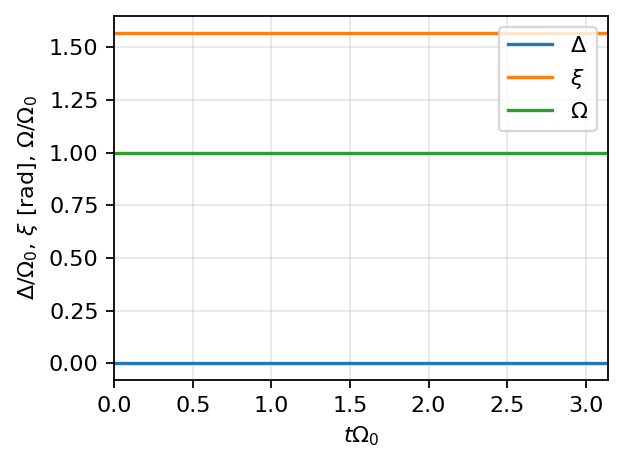

In [5]:
ro.characterization.plot_pulse(pulse_ansatz, optimized_params);